# Análise de Componentes Principais (PCA): O Hiperplano de Projeção

Neste notebook, exploramos a intuição geométrica por trás do PCA utilizando o *Ames Housing Dataset*. Quando trabalhamos com múltiplas variáveis correlacionadas, como a metragem do imóvel (`GrLivArea`), o número de quartos (`TotRmsAbvGrd`) e o tamanho da garagem (`GarageCars`), os dados tendem a se organizar em uma estrutura alongada no espaço.

O objetivo do PCA é encontrar um subespaço de menor dimensão (neste caso, um plano bidimensional) que minimize a perda de informação. Visualizaremos esse plano como um "espelho de vidro" que atravessa a nuvem de dados, permitindo-nos projetar pontos tridimensionais em uma superfície plana.

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- CONFIGURAÇÕES DE IDENTIDADE VISUAL (PALETA GRAN) ---
COR_AZUL_PRINCIPAL = "#0D134C"
COR_VERMELHO = "#DD303E"
COR_PRETO = "#000000"
COR_BRANCO = "#FFFFFF"
FUNDO_EIXOS = "#F9F9F9"

# Tipografia otimizada para legibilidade em PDFs
FONT_LABEL = 20
FONT_TICK = 18
FONT_SUBFIGURE = 24

# Configuração do tema base
sns.set_theme(style="whitegrid", rc={"axes.facecolor": FUNDO_EIXOS})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

## Preparação dos Dados e Redução de Dimensionalidade

Para que o PCA identifique corretamente as direções de variância, os dados devem estar na mesma escala. Aplicamos a padronização para que variáveis com grandezas diferentes (metros quadrados vs. unidades de quartos) contribuam igualmente para a análise.

In [23]:
# Definição do caminho relativo para o dataset
caminho_dados = os.path.join('..', 'data', 'ames_housing', 'train.csv')

try:
    df = pd.read_csv(caminho_dados)
    
    # Seleção de variáveis com alta correlação teórica
    colunas_alvo = ['GrLivArea', 'TotRmsAbvGrd', 'GarageCars']
    df_pca = df[colunas_alvo].dropna()
    
    # Padronização (Z-score)
    scaler = StandardScaler()
    dados_padronizados = scaler.fit_transform(df_pca)
    
    # Execução do PCA para 3 componentes
    pca = PCA(n_components=3)
    dados_transformados = pca.fit_transform(dados_padronizados)

except FileNotFoundError:
    print("Erro: Dataset 'train.csv' não encontrado na pasta '../data/ames_housing/'.")
    print("Por favor, verifique a estrutura de pastas antes de prosseguir.")
    raise SystemExit

## Visualização do Hiperplano de Projeção

Abaixo, apresentamos duas perspectivas do mesmo fenômeno:
- **(a) Espaço Tridimensional:** Exibe a nuvem de pontos original sendo atravessada pelo plano de projeção formado pelos dois primeiros componentes principais ($PC_1$ e $PC_2$). O efeito de transparência permite identificar quais imóveis estão "atrás" e quais estão "à frente" do plano.
- **(b) Espaço de Componentes:** Exibe a visão "achatada" ou projetada. É a perspectiva de quem olha exatamente de frente para o espelho de vidro, transformando os dados 3D em uma representação 2D eficiente.

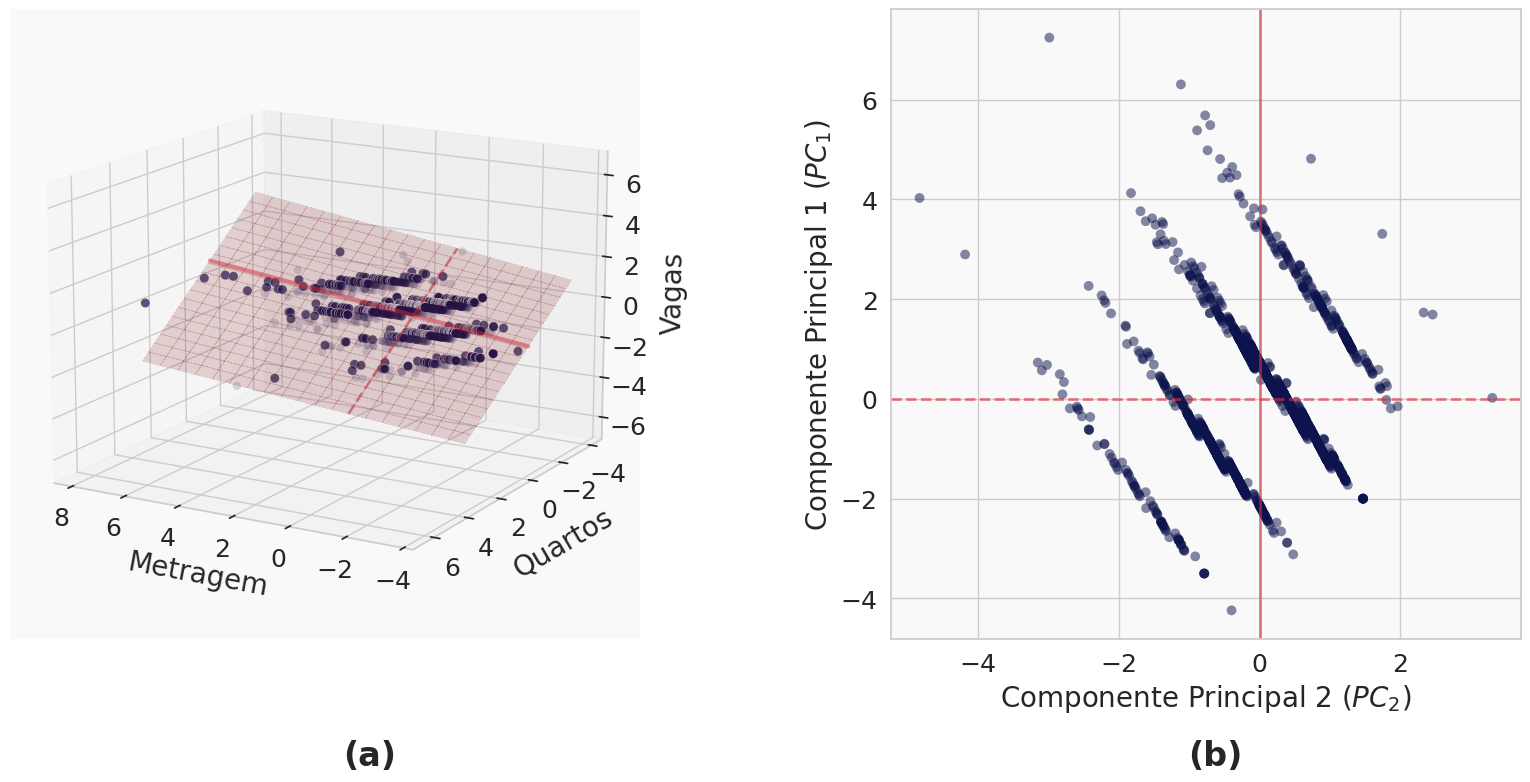

In [ ]:
fig = plt.figure(figsize=(18, 9))

# ---------------------------------------------------------
# Plot (a): Intersecção entre Nuvem de Dados e Plano PCA
# ---------------------------------------------------------
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_facecolor(FUNDO_EIXOS)

# Configuração de visualização da câmera
elev_val, azim_val = 15, 120
ax1.view_init(elev=elev_val, azim=azim_val)

# Extração dos vetores e componentes
v1, v2, v3 = pca.components_[0], pca.components_[1], pca.components_[2]
media = pca.mean_

# Cálculo vetorial para determinar a orientação da câmera em relação ao plano
# O produto escalar identifica se o vetor normal (PC3) aponta para o observador
phi, theta = np.deg2rad(azim_val), np.deg2rad(90 - elev_val)
cam_vec = np.array([np.sin(theta) * np.sin(phi), -np.sin(theta) * np.cos(phi), np.cos(theta)])
dot_product = np.dot(cam_vec, v3)

# Separação dos pontos em dois grupos: os que estão atrás do plano e os que estão na frente
# (do ponto de vista da câmera) utilizando as coordenadas do 3º Componente Principal
distancias = dados_transformados[:, 2] if dot_product > 0 else -dados_transformados[:, 2]
mask_atras, mask_frente = distancias < 0, distancias >= 0

# --- ORDEM DE RENDERIZAÇÃO POR CAMADAS (DEPTH SORTING MANUAL) ---

# 1. Camada de Fundo: Pontos situados atrás do hiperplano
ax1.scatter(dados_padronizados[mask_atras, 0], dados_padronizados[mask_atras, 1], 
            dados_padronizados[mask_atras, 2], alpha=0.15, color=COR_AZUL_PRINCIPAL, 
            edgecolor='none', s=35, zorder=1)

# 2. Camada Intermediária: O Hiperplano (Espelho de Vidro)
# Definimos a malha do plano com base na extensão dos dados projetados
range_pc1 = np.linspace(dados_transformados[:, 0].min(), dados_transformados[:, 0].max(), 20)
range_pc2 = np.linspace(dados_transformados[:, 1].min(), dados_transformados[:, 1].max(), 20)
xx, yy = np.meshgrid(range_pc1, range_pc2)

plano_x = media[0] + xx * v1[0] + yy * v2[0]
plano_y = media[1] + xx * v1[1] + yy * v2[1]
plano_z = media[2] + xx * v1[2] + yy * v2[2]

# Renderização da superfície sem linhas de grade (edgecolor='none') para evitar artefatos visuais
ax1.plot_surface(plano_x, plano_y, plano_z, color=COR_VERMELHO, alpha=0.18, 
                shade=True, edgecolor='none', antialiased=False, zorder=2)

# 3. Camada Intermediária: Eixos dos Componentes Principais (PCs)
# Plotamos as retas vermelhas após o plano e antes dos pontos da frente
proj1_min, proj1_max = np.min(dados_transformados[:, 0]), np.max(dados_transformados[:, 0])
proj2_min, proj2_max = np.min(dados_transformados[:, 1]), np.max(dados_transformados[:, 1])

# Definição geométrica dos eixos PC1 (sólido) e PC2 (tracejado)
linha_pc1 = np.vstack([media + proj1_min * v1, media + proj1_max * v1])
linha_pc2 = np.vstack([media + proj2_min * v2, media + proj2_max * v2])

ax1.plot(linha_pc1[:, 0], linha_pc1[:, 1], linha_pc1[:, 2], 
         color=COR_VERMELHO, linewidth=3, alpha=0.5, zorder=3)
ax1.plot(linha_pc2[:, 0], linha_pc2[:, 1], linha_pc2[:, 2], 
         color=COR_VERMELHO, linewidth=2, linestyle='--', alpha=0.5, zorder=3)

# 4. Camada de Primeiro Plano: Pontos situados à frente do hiperplano
# Estes pontos são plotados por último para garantir que sobreponham o vidro e os eixos
ax1.scatter(dados_padronizados[mask_frente, 0], dados_padronizados[mask_frente, 1], 
            dados_padronizados[mask_frente, 2], alpha=0.7, color=COR_AZUL_PRINCIPAL, 
            edgecolor=COR_BRANCO, linewidth=0.3, s=45, zorder=4)

# Formatação final dos eixos e labels
ax1.set_xlabel('Metragem', fontsize=FONT_LABEL, labelpad=12)
ax1.set_ylabel('Quartos', fontsize=FONT_LABEL, labelpad=12)
ax1.set_zlabel('Vagas', fontsize=FONT_LABEL, labelpad=10)
ax1.tick_params(axis='both', labelsize=FONT_TICK)

# ---------------------------------------------------------
# Plot (b): Projeção Bidimensional (PC2 vs PC1)
# ---------------------------------------------------------
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(dados_transformados[:, 1], dados_transformados[:, 0], 
            alpha=0.5, color=COR_AZUL_PRINCIPAL, edgecolor='none', s=50)

ax2.axhline(0, color=COR_VERMELHO, linestyle='--', linewidth=2, alpha=0.6)
ax2.axvline(0, color=COR_VERMELHO, linestyle='-', linewidth=2, alpha=0.6)

ax2.set_xlabel(r'Componente Principal 2 ($PC_2$)', fontsize=FONT_LABEL)
ax2.set_ylabel(r'Componente Principal 1 ($PC_1$)', fontsize=FONT_LABEL)
ax2.tick_params(axis='both', labelsize=FONT_TICK)
ax2.set_box_aspect(1)

# Alinhamento das letras identificadoras
fig.text(0.28, 0.08, '(a)', fontsize=FONT_SUBFIGURE, fontweight='bold', ha='center')
fig.text(0.75, 0.08, '(b)', fontsize=FONT_SUBFIGURE, fontweight='bold', ha='center')

# Ajustes de margens e salvamento
plt.tight_layout(w_pad=4.0)
fig.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.22) 

caminho_save = os.path.join('..', 'outputs', 'figures', 'aula_05')
os.makedirs(caminho_save, exist_ok=True)
plt.savefig(os.path.join(caminho_save, '03_efeito_pca_3d.png'), 
            dpi=300, bbox_inches='tight', pad_inches=0.4)

plt.show()